### Import Necessary Modules

In [56]:
import torch
import cv2
import argparse
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import models, transforms
from torchvision.models.swin_transformer import Swin_V2_B_Weights
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import requests
import warnings
from torch.utils.data import DataLoader
import matplotlib.style
from tqdm.auto import tqdm
import torch.optim as optim
import os
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

matplotlib.style.use('ggplot')
%matplotlib inline

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Resnet50 and Resnet18 Models for Classification

In [58]:
class ResNetModel50(nn.Module):
    def __init__(self, num_classes=2, weights=None):
        super(ResNetModel50, self).__init__()
        self.resnet = models.resnet50(weights=weights)
        # Modify the final layer to fit your task
        num_ftrs = self.resnet.fc.in_features

        if num_classes == 2:
            # Binary classification
            self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 128),
                nn.ReLU(),
                nn.Linear(128, 1),  # Single output for binary classification
                nn.Sigmoid()         # Sigmoid activation for binary classification
            )
        else:
            # Multi-class classification
            self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes)  # Output size matches the number of classes
                # No activation function here because CrossEntropyLoss expects raw logits
            )

    def forward(self, x):
        # Input shape: [batch_size, channels, height, width]
        output = self.resnet(x)
        return output

class ResNetModel18(nn.Module):
    def __init__(self, num_classes=2, weights=None):
        super(ResNetModel18, self).__init__()
        self.resnet = models.resnet18(weights=weights)
        # Modify the final layer to fit your task
        num_ftrs = self.resnet.fc.in_features

        if num_classes == 2:
            # Binary classification
            self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 128),
                nn.ReLU(),
                nn.Linear(128, 1),  # Single output for binary classification
                nn.Sigmoid()         # Sigmoid activation for binary classification
            )
        else:
            # Multi-class classification
            self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 128),
                nn.ReLU(),
                nn.Linear(128, num_classes)  # Output size matches the number of classes
                # No activation function here because CrossEntropyLoss expects raw logits
            )

    def forward(self, x):
        # Input shape: [batch_size, channels, height, width]
        output = self.resnet(x)
        return output

In [59]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-90, 90)),
    transforms.RandomRotation(degrees=(-180, 180)),
    transforms.RandomRotation(degrees=(-270, 270)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [61]:
# Datasets
train_dataset = ImageFolder(root='/media/imran4070/SSD/imran/datasets/classification/time/train', transform=train_transform)
valid_dataset = ImageFolder(root='/media/imran4070/SSD/imran/datasets/classification/time/valid', transform=valid_transform)
test_dataset = ImageFolder(root='/media/imran4070/SSD/imran/datasets/classification/time/test', transform=valid_transform)


In [62]:
len(train_dataset.classes)

144

In [63]:
batch_size = 512

In [64]:
# Dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [65]:
def save_model(epochs, model, optimizer, criterion, save_dir = './outputs', is_best = False):
    os.makedirs(save_dir, exist_ok=True)
    if is_best:
        save_path = os.path.join(save_dir, 'best.pth')
        torch.save({
            'epoch':epochs,
            'state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'loss':criterion
        }, save_path)
        print(f'Best model saved as {save_path}')
    else:
        save_path = os.path.join(save_dir, 'latest.pth')
        torch.save({
            'epoch':epochs,
            'state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'loss':criterion
        }, save_path)
        print(f'Latest model saved as {save_path}')

In [66]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, save_dir = './outputs'):
    os.makedirs(save_dir, exist_ok=True)
    # accuracy plots
    plt.figure(figsize=(10,7))
    plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
    plt.plot(valid_acc, color='blue', linestyle='-', label='validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(save_dir,'accuracy.png'))

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='red', linestyle='-', label='train loss')
    plt.plot(valid_loss, color='yellow', linestyle='-', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir,'loss.png'))

In [69]:
model = ResNetModel18(num_classes=144, weights=True)
model.to(device);

/home/imran4070/anaconda3/envs/torch_tf/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [70]:
# parameters
learning_rate = 1e-3
epochs = 300
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

### Training Function

In [71]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    print('Training....')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_running_loss/counter
    epoch_accuracy = 100. * (train_running_correct/len(train_loader.dataset))
    return epoch_loss, epoch_accuracy



### Validation Function

In [72]:
def validate(model, valid_loader, criterion):
    model.eval()
    print('Validating....')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            outputs = model(image)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        epoch_loss = valid_running_loss/counter
        epoch_accuracy = 100. * (valid_running_correct/len(valid_loader.dataset))
        return epoch_loss, epoch_accuracy


In [73]:
save_dir = './resnet18_outputs'
os.makedirs(save_dir, exist_ok=True)

[INFO]: Epoch 1/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Training loss: 4.928	Training Accuracy: 0.87
Validation loss: 5.248	Validation Accuracy: 1.53
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 2/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 4.345	Training Accuracy: 2.43
Validation loss: 3.882	Validation Accuracy: 4.24
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 3/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.74s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 3.498	Training Accuracy: 5.38
Validation loss: 3.126	Validation Accuracy: 8.06
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 4/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.43s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 3.045	Training Accuracy: 8.40
Validation loss: 3.157	Validation Accuracy: 6.67
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 5/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


Training loss: 2.813	Training Accuracy: 9.92
Validation loss: 2.697	Validation Accuracy: 12.43
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 6/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Training loss: 2.680	Training Accuracy: 11.97
Validation loss: 2.702	Validation Accuracy: 9.93
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 7/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Training loss: 2.601	Training Accuracy: 12.28
Validation loss: 2.536	Validation Accuracy: 12.99
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 8/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 2.497	Training Accuracy: 13.98
Validation loss: 2.482	Validation Accuracy: 12.64
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 9/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Training loss: 2.440	Training Accuracy: 14.64
Validation loss: 2.432	Validation Accuracy: 13.75
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 10/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Training loss: 2.390	Training Accuracy: 15.06
Validation loss: 2.568	Validation Accuracy: 15.28
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 11/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Training loss: 2.337	Training Accuracy: 16.59
Validation loss: 2.464	Validation Accuracy: 14.51
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 12/300
Training....


100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Training loss: 2.297	Training Accuracy: 16.46
Validation loss: 2.742	Validation Accuracy: 13.96
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 13/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.65s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Training loss: 2.250	Training Accuracy: 17.29
Validation loss: 2.335	Validation Accuracy: 13.96
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 14/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Training loss: 2.184	Training Accuracy: 18.06
Validation loss: 2.298	Validation Accuracy: 18.40
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 15/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Training loss: 2.128	Training Accuracy: 19.44
Validation loss: 2.271	Validation Accuracy: 19.10
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 16/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.43s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 2.082	Training Accuracy: 20.96
Validation loss: 2.356	Validation Accuracy: 17.15
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 17/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Training loss: 2.100	Training Accuracy: 20.04
Validation loss: 2.391	Validation Accuracy: 17.50
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 18/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Training loss: 2.077	Training Accuracy: 20.63
Validation loss: 2.178	Validation Accuracy: 19.65
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 19/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


Training loss: 2.019	Training Accuracy: 21.64
Validation loss: 2.068	Validation Accuracy: 21.81
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 20/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.70s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Training loss: 1.959	Training Accuracy: 23.12
Validation loss: 2.239	Validation Accuracy: 19.93
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 21/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Training loss: 1.969	Training Accuracy: 22.34
Validation loss: 2.305	Validation Accuracy: 17.64
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 22/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Training loss: 1.938	Training Accuracy: 23.59
Validation loss: 2.327	Validation Accuracy: 20.56
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 23/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Training loss: 1.850	Training Accuracy: 25.43
Validation loss: 2.320	Validation Accuracy: 17.99
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 24/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Training loss: 1.913	Training Accuracy: 24.08
Validation loss: 2.225	Validation Accuracy: 17.99
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 25/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 1.929	Training Accuracy: 23.06
Validation loss: 2.355	Validation Accuracy: 19.24
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 26/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.965	Training Accuracy: 22.58
Validation loss: 2.219	Validation Accuracy: 20.69
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 27/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.874	Training Accuracy: 25.30
Validation loss: 2.286	Validation Accuracy: 20.35
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 28/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Training loss: 1.777	Training Accuracy: 27.23
Validation loss: 2.219	Validation Accuracy: 20.49
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 29/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Training loss: 1.802	Training Accuracy: 26.81
Validation loss: 2.164	Validation Accuracy: 20.97
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 30/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.48s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Training loss: 1.836	Training Accuracy: 25.90
Validation loss: 1.922	Validation Accuracy: 28.19
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 31/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Training loss: 1.836	Training Accuracy: 26.37
Validation loss: 2.043	Validation Accuracy: 22.22
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 32/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.47s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Training loss: 1.760	Training Accuracy: 27.65
Validation loss: 2.263	Validation Accuracy: 19.38
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 33/300
Training....


100%|██████████| 23/23 [00:45<00:00,  1.96s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 1.808	Training Accuracy: 25.69
Validation loss: 2.032	Validation Accuracy: 24.44
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 34/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.83s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


Training loss: 1.745	Training Accuracy: 28.44
Validation loss: 2.287	Validation Accuracy: 22.15
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 35/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.71s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.746	Training Accuracy: 27.10
Validation loss: 2.214	Validation Accuracy: 20.00
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 36/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Training loss: 1.724	Training Accuracy: 27.68
Validation loss: 2.150	Validation Accuracy: 22.22
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 37/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.694	Training Accuracy: 29.34
Validation loss: 2.361	Validation Accuracy: 19.38
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 38/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Training loss: 1.708	Training Accuracy: 28.02
Validation loss: 2.048	Validation Accuracy: 24.17
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 39/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 1.654	Training Accuracy: 30.43
Validation loss: 2.285	Validation Accuracy: 19.79
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 40/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.674	Training Accuracy: 29.45
Validation loss: 2.130	Validation Accuracy: 21.94
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 41/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Training loss: 1.727	Training Accuracy: 28.45
Validation loss: 2.570	Validation Accuracy: 16.39
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 42/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 1.667	Training Accuracy: 29.02
Validation loss: 1.891	Validation Accuracy: 28.54
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 43/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.40s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Training loss: 1.706	Training Accuracy: 28.66
Validation loss: 2.325	Validation Accuracy: 20.62
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 44/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 1.696	Training Accuracy: 29.71
Validation loss: 2.447	Validation Accuracy: 19.44
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 45/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Training loss: 1.621	Training Accuracy: 31.68
Validation loss: 2.021	Validation Accuracy: 24.65
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 46/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.641	Training Accuracy: 30.23
Validation loss: 2.025	Validation Accuracy: 25.21
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 47/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Training loss: 1.714	Training Accuracy: 27.80
Validation loss: 2.056	Validation Accuracy: 26.81
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 48/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.69s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Training loss: 1.678	Training Accuracy: 29.99
Validation loss: 2.111	Validation Accuracy: 24.65
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 49/300
Training....


100%|██████████| 23/23 [00:41<00:00,  1.79s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.58it/s]


Training loss: 1.617	Training Accuracy: 30.72
Validation loss: 2.145	Validation Accuracy: 25.28
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 50/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Training loss: 1.600	Training Accuracy: 31.43
Validation loss: 1.707	Validation Accuracy: 30.76
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 51/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Training loss: 1.570	Training Accuracy: 32.80
Validation loss: 2.021	Validation Accuracy: 21.53
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 52/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.48s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Training loss: 1.603	Training Accuracy: 31.29
Validation loss: 1.875	Validation Accuracy: 27.01
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 53/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.42s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Training loss: 1.631	Training Accuracy: 30.53
Validation loss: 1.839	Validation Accuracy: 30.07
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 54/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 1.611	Training Accuracy: 31.40
Validation loss: 1.981	Validation Accuracy: 25.07
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 55/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Training loss: 1.604	Training Accuracy: 31.02
Validation loss: 2.016	Validation Accuracy: 23.96
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 56/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 1.628	Training Accuracy: 31.21
Validation loss: 2.266	Validation Accuracy: 22.64
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 57/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 1.566	Training Accuracy: 32.07
Validation loss: 1.877	Validation Accuracy: 28.61
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 58/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.42s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 1.623	Training Accuracy: 30.69
Validation loss: 1.990	Validation Accuracy: 25.49
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 59/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.66s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Training loss: 1.552	Training Accuracy: 32.61
Validation loss: 1.895	Validation Accuracy: 26.67
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 60/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.47s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Training loss: 1.556	Training Accuracy: 32.36
Validation loss: 1.667	Validation Accuracy: 30.63
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 61/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Training loss: 1.584	Training Accuracy: 31.61
Validation loss: 2.138	Validation Accuracy: 25.21
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 62/300
Training....


100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Training loss: 1.547	Training Accuracy: 32.51
Validation loss: 1.845	Validation Accuracy: 26.04
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 63/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Training loss: 1.562	Training Accuracy: 32.43
Validation loss: 1.966	Validation Accuracy: 24.72
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 64/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.534	Training Accuracy: 32.66
Validation loss: 1.970	Validation Accuracy: 30.42
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 65/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.42s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.47it/s]


Training loss: 1.504	Training Accuracy: 33.98
Validation loss: 1.892	Validation Accuracy: 27.57
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 66/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.546	Training Accuracy: 33.57
Validation loss: 2.128	Validation Accuracy: 26.04
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 67/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 1.511	Training Accuracy: 34.18
Validation loss: 1.911	Validation Accuracy: 26.94
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 68/300
Training....


100%|██████████| 23/23 [00:47<00:00,  2.08s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.494	Training Accuracy: 35.23
Validation loss: 2.047	Validation Accuracy: 28.12
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 69/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 1.509	Training Accuracy: 33.98
Validation loss: 1.694	Validation Accuracy: 34.44
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 70/300
Training....


100%|██████████| 23/23 [00:44<00:00,  1.93s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Training loss: 1.441	Training Accuracy: 37.00
Validation loss: 1.652	Validation Accuracy: 33.06
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 71/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.66s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.43it/s]


Training loss: 1.538	Training Accuracy: 32.64
Validation loss: 2.064	Validation Accuracy: 29.51
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 72/300
Training....


100%|██████████| 23/23 [00:44<00:00,  1.94s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 1.519	Training Accuracy: 32.92
Validation loss: 1.766	Validation Accuracy: 31.67
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 73/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Training loss: 1.439	Training Accuracy: 36.66
Validation loss: 1.776	Validation Accuracy: 31.67
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 74/300
Training....


100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 1.515	Training Accuracy: 34.82
Validation loss: 2.140	Validation Accuracy: 26.25
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 75/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Training loss: 1.469	Training Accuracy: 34.47
Validation loss: 1.878	Validation Accuracy: 29.17
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 76/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 1.465	Training Accuracy: 35.62
Validation loss: 1.771	Validation Accuracy: 28.96
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 77/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Training loss: 1.446	Training Accuracy: 35.43
Validation loss: 1.770	Validation Accuracy: 30.97
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 78/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.492	Training Accuracy: 35.58
Validation loss: 2.025	Validation Accuracy: 24.65
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 79/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.21it/s]


Training loss: 1.437	Training Accuracy: 36.61
Validation loss: 2.130	Validation Accuracy: 25.42
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 80/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Training loss: 1.404	Training Accuracy: 37.65
Validation loss: 2.038	Validation Accuracy: 28.82
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 81/300
Training....


100%|██████████| 23/23 [00:41<00:00,  1.79s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Training loss: 1.407	Training Accuracy: 37.07
Validation loss: 1.902	Validation Accuracy: 28.61
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 82/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.406	Training Accuracy: 37.49
Validation loss: 2.230	Validation Accuracy: 26.39
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 83/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.67s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Training loss: 1.415	Training Accuracy: 37.71
Validation loss: 1.734	Validation Accuracy: 33.19
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 84/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Training loss: 1.391	Training Accuracy: 37.64
Validation loss: 1.727	Validation Accuracy: 32.36
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 85/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Training loss: 1.368	Training Accuracy: 38.87
Validation loss: 2.026	Validation Accuracy: 26.88
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 86/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Training loss: 1.349	Training Accuracy: 39.69
Validation loss: 1.614	Validation Accuracy: 35.97
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 87/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.40s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Training loss: 1.348	Training Accuracy: 39.62
Validation loss: 1.728	Validation Accuracy: 33.26
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 88/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.392	Training Accuracy: 39.62
Validation loss: 1.505	Validation Accuracy: 38.89
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 89/300
Training....


100%|██████████| 23/23 [00:31<00:00,  1.38s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Training loss: 1.403	Training Accuracy: 38.52
Validation loss: 1.749	Validation Accuracy: 35.07
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 90/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 1.341	Training Accuracy: 40.00
Validation loss: 1.668	Validation Accuracy: 34.79
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 91/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.301	Training Accuracy: 41.48
Validation loss: 1.616	Validation Accuracy: 40.14
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 92/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Training loss: 1.310	Training Accuracy: 40.80
Validation loss: 1.548	Validation Accuracy: 34.44
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 93/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.47s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Training loss: 1.346	Training Accuracy: 39.47
Validation loss: 1.822	Validation Accuracy: 33.40
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 94/300
Training....


100%|██████████| 23/23 [00:41<00:00,  1.80s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.321	Training Accuracy: 40.41
Validation loss: 1.644	Validation Accuracy: 35.90
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 95/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Training loss: 1.304	Training Accuracy: 41.14
Validation loss: 1.640	Validation Accuracy: 37.01
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 96/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 1.327	Training Accuracy: 40.35
Validation loss: 1.688	Validation Accuracy: 37.78
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 97/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.48s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.279	Training Accuracy: 43.05
Validation loss: 1.519	Validation Accuracy: 41.25
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 98/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.43s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 1.308	Training Accuracy: 41.37
Validation loss: 1.620	Validation Accuracy: 39.24
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 99/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.281	Training Accuracy: 42.78
Validation loss: 1.666	Validation Accuracy: 34.44
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 100/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.83s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Training loss: 1.296	Training Accuracy: 41.97
Validation loss: 1.539	Validation Accuracy: 40.14
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 101/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.48it/s]


Training loss: 1.286	Training Accuracy: 43.25
Validation loss: 1.743	Validation Accuracy: 38.68
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 102/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.295	Training Accuracy: 42.07
Validation loss: 1.737	Validation Accuracy: 35.62
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 103/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Training loss: 1.221	Training Accuracy: 44.28
Validation loss: 1.372	Validation Accuracy: 43.89
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 104/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Training loss: 1.239	Training Accuracy: 43.86
Validation loss: 2.070	Validation Accuracy: 38.12
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 105/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.288	Training Accuracy: 42.54
Validation loss: 1.524	Validation Accuracy: 40.56
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 106/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Training loss: 1.218	Training Accuracy: 45.68
Validation loss: 1.504	Validation Accuracy: 41.74
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 107/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.69s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 1.195	Training Accuracy: 45.83
Validation loss: 1.799	Validation Accuracy: 38.26
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 108/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.69s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.193	Training Accuracy: 46.64
Validation loss: 1.823	Validation Accuracy: 34.79
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 109/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.65s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 1.264	Training Accuracy: 43.54
Validation loss: 1.467	Validation Accuracy: 44.17
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 110/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Training loss: 1.203	Training Accuracy: 45.75
Validation loss: 1.677	Validation Accuracy: 35.00
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 111/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Training loss: 1.174	Training Accuracy: 46.76
Validation loss: 1.812	Validation Accuracy: 36.67
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 112/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.202	Training Accuracy: 45.30
Validation loss: 1.769	Validation Accuracy: 34.51
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 113/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.153	Training Accuracy: 47.01
Validation loss: 1.507	Validation Accuracy: 40.97
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 114/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.66s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 1.118	Training Accuracy: 48.35
Validation loss: 1.458	Validation Accuracy: 40.90
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 115/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.105	Training Accuracy: 49.73
Validation loss: 1.770	Validation Accuracy: 37.85
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 116/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Training loss: 1.115	Training Accuracy: 48.15
Validation loss: 1.575	Validation Accuracy: 42.43
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 117/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.67s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 1.071	Training Accuracy: 50.19
Validation loss: 1.654	Validation Accuracy: 35.83
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 118/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Training loss: 1.124	Training Accuracy: 48.63
Validation loss: 1.441	Validation Accuracy: 46.60
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 119/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 1.123	Training Accuracy: 49.04
Validation loss: 1.627	Validation Accuracy: 41.88
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 120/300
Training....


100%|██████████| 23/23 [00:30<00:00,  1.34s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Training loss: 1.081	Training Accuracy: 50.71
Validation loss: 1.714	Validation Accuracy: 37.78
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 121/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Training loss: 1.035	Training Accuracy: 52.22
Validation loss: 1.370	Validation Accuracy: 42.29
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 122/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.69s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


Training loss: 0.994	Training Accuracy: 54.20
Validation loss: 1.825	Validation Accuracy: 35.56
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 123/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.83s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Training loss: 1.021	Training Accuracy: 52.85
Validation loss: 1.743	Validation Accuracy: 37.57
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 124/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 1.032	Training Accuracy: 53.03
Validation loss: 1.970	Validation Accuracy: 33.19
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 125/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 0.951	Training Accuracy: 55.49
Validation loss: 1.547	Validation Accuracy: 45.76
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 126/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 0.953	Training Accuracy: 56.02
Validation loss: 1.380	Validation Accuracy: 44.51
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 127/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.933	Training Accuracy: 57.07
Validation loss: 3.980	Validation Accuracy: 17.22
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 128/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Training loss: 0.927	Training Accuracy: 57.34
Validation loss: 1.333	Validation Accuracy: 47.85
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 129/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.47s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.23it/s]


Training loss: 0.930	Training Accuracy: 56.93
Validation loss: 2.485	Validation Accuracy: 31.94
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 130/300
Training....


100%|██████████| 23/23 [00:43<00:00,  1.89s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Training loss: 0.937	Training Accuracy: 57.43
Validation loss: 1.508	Validation Accuracy: 44.03
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 131/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 0.940	Training Accuracy: 57.13
Validation loss: 1.824	Validation Accuracy: 44.03
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 132/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Validating....


100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


Training loss: 0.915	Training Accuracy: 58.39
Validation loss: 1.319	Validation Accuracy: 48.96
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 133/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.66s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 0.873	Training Accuracy: 60.48
Validation loss: 1.548	Validation Accuracy: 41.53
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 134/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Training loss: 0.861	Training Accuracy: 61.63
Validation loss: 1.279	Validation Accuracy: 53.68
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 135/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 0.912	Training Accuracy: 59.68
Validation loss: 1.473	Validation Accuracy: 46.88
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 136/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 0.847	Training Accuracy: 62.25
Validation loss: 3.236	Validation Accuracy: 24.65
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 137/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 0.805	Training Accuracy: 64.48
Validation loss: 1.735	Validation Accuracy: 40.56
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 138/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.87s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.22it/s]


Training loss: 0.821	Training Accuracy: 63.86
Validation loss: 2.095	Validation Accuracy: 36.39
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 139/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Training loss: 0.790	Training Accuracy: 65.14
Validation loss: 1.634	Validation Accuracy: 47.92
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 140/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Training loss: 0.834	Training Accuracy: 63.31
Validation loss: 1.774	Validation Accuracy: 42.15
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 141/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.65s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Training loss: 0.792	Training Accuracy: 65.23
Validation loss: 1.699	Validation Accuracy: 46.04
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 142/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.43s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.736	Training Accuracy: 68.02
Validation loss: 1.464	Validation Accuracy: 50.56
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 143/300
Training....


100%|██████████| 23/23 [00:45<00:00,  1.99s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 0.724	Training Accuracy: 68.90
Validation loss: 1.999	Validation Accuracy: 38.26
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 144/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Training loss: 0.719	Training Accuracy: 68.69
Validation loss: 2.252	Validation Accuracy: 34.03
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 145/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Training loss: 0.773	Training Accuracy: 67.49
Validation loss: 3.433	Validation Accuracy: 26.04
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 146/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.43s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Training loss: 0.744	Training Accuracy: 68.42
Validation loss: 1.572	Validation Accuracy: 48.26
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 147/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 0.690	Training Accuracy: 71.15
Validation loss: 1.557	Validation Accuracy: 52.85
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 148/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Training loss: 0.690	Training Accuracy: 70.91
Validation loss: 10.956	Validation Accuracy: 9.51
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 149/300
Training....


100%|██████████| 23/23 [00:44<00:00,  1.92s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Training loss: 0.666	Training Accuracy: 72.06
Validation loss: 1.478	Validation Accuracy: 51.88
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 150/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


Training loss: 0.636	Training Accuracy: 73.74
Validation loss: 1.237	Validation Accuracy: 58.61
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 151/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Training loss: 0.626	Training Accuracy: 73.98
Validation loss: 1.391	Validation Accuracy: 57.43
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 152/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Training loss: 0.611	Training Accuracy: 74.32
Validation loss: 3.628	Validation Accuracy: 25.62
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 153/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Training loss: 0.584	Training Accuracy: 75.69
Validation loss: 1.676	Validation Accuracy: 51.04
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 154/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.87s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Training loss: 0.574	Training Accuracy: 76.11
Validation loss: 2.188	Validation Accuracy: 42.43
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 155/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 0.551	Training Accuracy: 77.59
Validation loss: 1.337	Validation Accuracy: 55.76
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 156/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 0.550	Training Accuracy: 77.07
Validation loss: 0.994	Validation Accuracy: 64.72
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 157/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Training loss: 0.526	Training Accuracy: 79.13
Validation loss: 1.434	Validation Accuracy: 54.10
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 158/300
Training....


100%|██████████| 23/23 [00:43<00:00,  1.89s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 0.541	Training Accuracy: 78.58
Validation loss: 3.319	Validation Accuracy: 31.18
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 159/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.471	Training Accuracy: 81.55
Validation loss: 1.995	Validation Accuracy: 41.81
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 160/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 0.479	Training Accuracy: 81.28
Validation loss: 1.638	Validation Accuracy: 52.50
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 161/300
Training....


100%|██████████| 23/23 [00:45<00:00,  2.00s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Training loss: 0.425	Training Accuracy: 83.13
Validation loss: 0.945	Validation Accuracy: 71.11
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 162/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Training loss: 0.422	Training Accuracy: 83.58
Validation loss: 0.988	Validation Accuracy: 69.24
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 163/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Training loss: 0.393	Training Accuracy: 84.30
Validation loss: 1.117	Validation Accuracy: 62.92
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 164/300
Training....


100%|██████████| 23/23 [00:31<00:00,  1.39s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Training loss: 0.377	Training Accuracy: 85.50
Validation loss: 1.310	Validation Accuracy: 60.62
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 165/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.340	Training Accuracy: 86.69
Validation loss: 0.973	Validation Accuracy: 68.61
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 166/300
Training....


100%|██████████| 23/23 [00:43<00:00,  1.88s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Training loss: 0.328	Training Accuracy: 87.27
Validation loss: 1.012	Validation Accuracy: 71.46
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 167/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.70s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.326	Training Accuracy: 87.43
Validation loss: 2.197	Validation Accuracy: 52.78
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 168/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Training loss: 0.309	Training Accuracy: 87.93
Validation loss: 0.683	Validation Accuracy: 78.19
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 169/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.41s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Training loss: 0.313	Training Accuracy: 87.89
Validation loss: 1.771	Validation Accuracy: 52.43
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 170/300
Training....


100%|██████████| 23/23 [00:41<00:00,  1.81s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 0.312	Training Accuracy: 87.93
Validation loss: 0.766	Validation Accuracy: 75.35
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 171/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 0.303	Training Accuracy: 88.11
Validation loss: 0.703	Validation Accuracy: 76.18
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 172/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.290	Training Accuracy: 88.81
Validation loss: 0.622	Validation Accuracy: 78.26
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 173/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.65s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Training loss: 0.276	Training Accuracy: 89.25
Validation loss: 1.656	Validation Accuracy: 61.11
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 174/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Training loss: 0.292	Training Accuracy: 88.77
Validation loss: 1.896	Validation Accuracy: 55.90
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 175/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.259	Training Accuracy: 90.11
Validation loss: 1.105	Validation Accuracy: 67.08
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 176/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.61s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.44it/s]


Training loss: 0.246	Training Accuracy: 90.49
Validation loss: 0.583	Validation Accuracy: 80.28
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 177/300
Training....


100%|██████████| 23/23 [00:43<00:00,  1.87s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Training loss: 0.232	Training Accuracy: 90.87
Validation loss: 2.225	Validation Accuracy: 46.94
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 178/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.65s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Training loss: 0.224	Training Accuracy: 91.21
Validation loss: 1.257	Validation Accuracy: 67.29
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 179/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.68s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Training loss: 0.226	Training Accuracy: 91.09
Validation loss: 1.506	Validation Accuracy: 60.00
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 180/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.74s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.217	Training Accuracy: 91.66
Validation loss: 1.290	Validation Accuracy: 65.21
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 181/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Training loss: 0.199	Training Accuracy: 92.10
Validation loss: 0.712	Validation Accuracy: 79.31
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 182/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Training loss: 0.215	Training Accuracy: 91.68
Validation loss: 0.479	Validation Accuracy: 85.00
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 183/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Training loss: 0.193	Training Accuracy: 92.53
Validation loss: 0.553	Validation Accuracy: 82.57
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 184/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.78s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Training loss: 0.192	Training Accuracy: 92.55
Validation loss: 0.507	Validation Accuracy: 85.49
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 185/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Training loss: 0.202	Training Accuracy: 92.06
Validation loss: 1.233	Validation Accuracy: 63.54
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 186/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.199	Training Accuracy: 92.09
Validation loss: 0.539	Validation Accuracy: 83.68
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 187/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Training loss: 0.184	Training Accuracy: 92.80
Validation loss: 0.594	Validation Accuracy: 81.32
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 188/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Training loss: 0.179	Training Accuracy: 93.02
Validation loss: 0.398	Validation Accuracy: 87.50
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 189/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.172	Training Accuracy: 93.32
Validation loss: 0.511	Validation Accuracy: 83.47
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 190/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.161	Training Accuracy: 93.60
Validation loss: 0.608	Validation Accuracy: 79.86
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 191/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.26it/s]


Training loss: 0.172	Training Accuracy: 93.26
Validation loss: 0.576	Validation Accuracy: 83.75
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 192/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.14it/s]


Training loss: 0.178	Training Accuracy: 92.89
Validation loss: 0.428	Validation Accuracy: 86.94
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 193/300
Training....


100%|██████████| 23/23 [00:45<00:00,  1.98s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Training loss: 0.157	Training Accuracy: 93.85
Validation loss: 0.490	Validation Accuracy: 84.51
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 194/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Training loss: 0.157	Training Accuracy: 94.11
Validation loss: 0.330	Validation Accuracy: 88.82
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 195/300
Training....


100%|██████████| 23/23 [00:45<00:00,  1.99s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Training loss: 0.169	Training Accuracy: 93.55
Validation loss: 0.428	Validation Accuracy: 87.15
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 196/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Training loss: 0.165	Training Accuracy: 93.75
Validation loss: 0.642	Validation Accuracy: 82.57
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 197/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Training loss: 0.186	Training Accuracy: 92.69
Validation loss: 1.010	Validation Accuracy: 74.17
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 198/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 0.165	Training Accuracy: 93.48
Validation loss: 0.947	Validation Accuracy: 74.10
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 199/300
Training....


100%|██████████| 23/23 [00:43<00:00,  1.89s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.166	Training Accuracy: 93.63
Validation loss: 1.034	Validation Accuracy: 73.54
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 200/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 0.162	Training Accuracy: 93.63
Validation loss: 1.438	Validation Accuracy: 66.32
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 201/300
Training....


100%|██████████| 23/23 [00:48<00:00,  2.13s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Training loss: 0.157	Training Accuracy: 93.87
Validation loss: 1.429	Validation Accuracy: 64.24
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 202/300
Training....


100%|██████████| 23/23 [00:48<00:00,  2.13s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Training loss: 0.160	Training Accuracy: 93.82
Validation loss: 0.708	Validation Accuracy: 80.28
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 203/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Training loss: 0.149	Training Accuracy: 94.06
Validation loss: 0.479	Validation Accuracy: 86.60
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 204/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Training loss: 0.151	Training Accuracy: 94.18
Validation loss: 0.396	Validation Accuracy: 88.33
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 205/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 0.146	Training Accuracy: 94.38
Validation loss: 1.238	Validation Accuracy: 72.15
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 206/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.145	Training Accuracy: 94.35
Validation loss: 0.430	Validation Accuracy: 88.12
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 207/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 0.127	Training Accuracy: 95.18
Validation loss: 1.155	Validation Accuracy: 69.03
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 208/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.47s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Training loss: 0.134	Training Accuracy: 94.72
Validation loss: 0.596	Validation Accuracy: 82.43
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 209/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.69s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Training loss: 0.121	Training Accuracy: 95.11
Validation loss: 0.431	Validation Accuracy: 87.01
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 210/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.84s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.32it/s]


Training loss: 0.123	Training Accuracy: 94.96
Validation loss: 1.287	Validation Accuracy: 70.14
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 211/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 0.123	Training Accuracy: 95.23
Validation loss: 0.392	Validation Accuracy: 88.06
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 212/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.86s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Training loss: 0.115	Training Accuracy: 95.38
Validation loss: 0.330	Validation Accuracy: 89.44
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 213/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.61s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Training loss: 0.117	Training Accuracy: 95.56
Validation loss: 0.362	Validation Accuracy: 89.10
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 214/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.68s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Training loss: 0.115	Training Accuracy: 95.64
Validation loss: 0.803	Validation Accuracy: 82.78
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 215/300
Training....


100%|██████████| 23/23 [00:42<00:00,  1.87s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Training loss: 0.119	Training Accuracy: 95.20
Validation loss: 6.690	Validation Accuracy: 25.42
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 216/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.111	Training Accuracy: 95.79
Validation loss: 0.435	Validation Accuracy: 87.57
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 217/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.69s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 0.125	Training Accuracy: 95.01
Validation loss: 0.343	Validation Accuracy: 91.60
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 218/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.41s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Training loss: 0.108	Training Accuracy: 95.85
Validation loss: 0.388	Validation Accuracy: 87.08
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 219/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Training loss: 0.111	Training Accuracy: 95.67
Validation loss: 0.313	Validation Accuracy: 89.44
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 220/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Training loss: 0.124	Training Accuracy: 95.23
Validation loss: 0.452	Validation Accuracy: 88.82
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 221/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.15it/s]


Training loss: 0.108	Training Accuracy: 95.64
Validation loss: 0.453	Validation Accuracy: 86.88
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 222/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Training loss: 0.117	Training Accuracy: 95.48
Validation loss: 0.285	Validation Accuracy: 91.25
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 223/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 0.122	Training Accuracy: 95.50
Validation loss: 0.836	Validation Accuracy: 76.53
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 224/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.08it/s]


Training loss: 0.109	Training Accuracy: 95.80
Validation loss: 0.447	Validation Accuracy: 87.57
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 225/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Training loss: 0.103	Training Accuracy: 95.95
Validation loss: 0.289	Validation Accuracy: 92.43
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 226/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.107	Training Accuracy: 95.82
Validation loss: 0.336	Validation Accuracy: 89.65
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 227/300
Training....


100%|██████████| 23/23 [00:41<00:00,  1.80s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Training loss: 0.110	Training Accuracy: 95.75
Validation loss: 0.641	Validation Accuracy: 82.99
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 228/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.48s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Training loss: 0.110	Training Accuracy: 95.72
Validation loss: 1.037	Validation Accuracy: 70.76
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 229/300
Training....


100%|██████████| 23/23 [00:31<00:00,  1.37s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 0.099	Training Accuracy: 96.13
Validation loss: 0.768	Validation Accuracy: 78.75
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 230/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 0.105	Training Accuracy: 95.96
Validation loss: 1.303	Validation Accuracy: 70.42
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 231/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 0.097	Training Accuracy: 96.22
Validation loss: 0.252	Validation Accuracy: 92.64
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 232/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.71s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 0.105	Training Accuracy: 95.87
Validation loss: 0.345	Validation Accuracy: 89.31
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 233/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Training loss: 0.113	Training Accuracy: 95.85
Validation loss: 0.795	Validation Accuracy: 80.49
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 234/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.112	Training Accuracy: 95.44
Validation loss: 0.981	Validation Accuracy: 75.42
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 235/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Training loss: 0.101	Training Accuracy: 95.79
Validation loss: 0.413	Validation Accuracy: 88.47
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 236/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.70s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Training loss: 0.095	Training Accuracy: 96.03
Validation loss: 1.047	Validation Accuracy: 75.83
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 237/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Training loss: 0.092	Training Accuracy: 96.16
Validation loss: 0.159	Validation Accuracy: 94.31
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 238/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.99it/s]


Training loss: 0.088	Training Accuracy: 96.48
Validation loss: 0.893	Validation Accuracy: 78.68
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 239/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.71s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.111	Training Accuracy: 95.77
Validation loss: 6.395	Validation Accuracy: 28.40
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 240/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Training loss: 0.107	Training Accuracy: 95.80
Validation loss: 0.756	Validation Accuracy: 84.72
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 241/300
Training....


100%|██████████| 23/23 [00:43<00:00,  1.90s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.30it/s]


Training loss: 0.106	Training Accuracy: 95.82
Validation loss: 1.152	Validation Accuracy: 69.79
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 242/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Training loss: 0.099	Training Accuracy: 95.90
Validation loss: 0.283	Validation Accuracy: 91.53
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 243/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 0.096	Training Accuracy: 96.29
Validation loss: 0.907	Validation Accuracy: 78.68
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 244/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Training loss: 0.098	Training Accuracy: 96.00
Validation loss: 0.422	Validation Accuracy: 87.29
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 245/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.087	Training Accuracy: 96.55
Validation loss: 0.230	Validation Accuracy: 93.06
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 246/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Training loss: 0.087	Training Accuracy: 96.54
Validation loss: 0.362	Validation Accuracy: 89.58
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 247/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.66s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 0.086	Training Accuracy: 96.60
Validation loss: 0.245	Validation Accuracy: 92.85
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 248/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Training loss: 0.089	Training Accuracy: 96.51
Validation loss: 0.789	Validation Accuracy: 81.46
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 249/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


Training loss: 0.091	Training Accuracy: 96.34
Validation loss: 0.660	Validation Accuracy: 82.08
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 250/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.089	Training Accuracy: 96.45
Validation loss: 0.277	Validation Accuracy: 92.43
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 251/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.40s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Training loss: 0.081	Training Accuracy: 96.77
Validation loss: 0.272	Validation Accuracy: 92.64
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 252/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.50it/s]


Training loss: 0.074	Training Accuracy: 96.96
Validation loss: 0.339	Validation Accuracy: 90.49
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 253/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Training loss: 0.075	Training Accuracy: 96.81
Validation loss: 0.262	Validation Accuracy: 91.60
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 254/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


Training loss: 0.091	Training Accuracy: 96.43
Validation loss: 0.248	Validation Accuracy: 93.19
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 255/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Training loss: 0.085	Training Accuracy: 96.74
Validation loss: 0.394	Validation Accuracy: 90.90
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 256/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Training loss: 0.098	Training Accuracy: 96.15
Validation loss: 0.740	Validation Accuracy: 82.08
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 257/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


Training loss: 0.098	Training Accuracy: 96.04
Validation loss: 0.327	Validation Accuracy: 90.21
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 258/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.64s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Training loss: 0.097	Training Accuracy: 96.19
Validation loss: 0.367	Validation Accuracy: 92.01
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 259/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.62s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Training loss: 0.097	Training Accuracy: 96.18
Validation loss: 0.579	Validation Accuracy: 82.71
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 260/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 0.085	Training Accuracy: 96.61
Validation loss: 0.291	Validation Accuracy: 91.25
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 261/300
Training....


100%|██████████| 23/23 [00:32<00:00,  1.41s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Training loss: 0.085	Training Accuracy: 96.70
Validation loss: 0.246	Validation Accuracy: 94.10
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 262/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.67s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Training loss: 0.092	Training Accuracy: 96.51
Validation loss: 0.294	Validation Accuracy: 91.46
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 263/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.099	Training Accuracy: 96.21
Validation loss: 1.689	Validation Accuracy: 70.07
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 264/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Training loss: 0.104	Training Accuracy: 95.89
Validation loss: 0.148	Validation Accuracy: 95.00
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 265/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 0.097	Training Accuracy: 96.33
Validation loss: 0.384	Validation Accuracy: 89.38
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 266/300
Training....


100%|██████████| 23/23 [00:31<00:00,  1.38s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Training loss: 0.079	Training Accuracy: 96.74
Validation loss: 1.221	Validation Accuracy: 72.78
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 267/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.72s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.093	Training Accuracy: 96.37
Validation loss: 1.500	Validation Accuracy: 75.35
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 268/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 0.080	Training Accuracy: 96.87
Validation loss: 0.269	Validation Accuracy: 92.29
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 269/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.68s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]


Training loss: 0.080	Training Accuracy: 96.87
Validation loss: 0.204	Validation Accuracy: 94.10
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 270/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.078	Training Accuracy: 96.84
Validation loss: 0.222	Validation Accuracy: 94.44
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 271/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 0.089	Training Accuracy: 96.47
Validation loss: 0.707	Validation Accuracy: 82.57
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 272/300
Training....


100%|██████████| 23/23 [00:31<00:00,  1.36s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Training loss: 0.079	Training Accuracy: 96.88
Validation loss: 0.293	Validation Accuracy: 90.97
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 273/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Training loss: 0.069	Training Accuracy: 97.40
Validation loss: 1.088	Validation Accuracy: 75.62
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 274/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.48s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Training loss: 0.067	Training Accuracy: 97.30
Validation loss: 0.943	Validation Accuracy: 79.65
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 275/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Training loss: 0.068	Training Accuracy: 97.19
Validation loss: 0.732	Validation Accuracy: 83.40
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 276/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.93it/s]


Training loss: 0.074	Training Accuracy: 97.02
Validation loss: 0.505	Validation Accuracy: 85.76
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 277/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.44s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.077	Training Accuracy: 97.12
Validation loss: 0.375	Validation Accuracy: 89.44
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 278/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.075	Training Accuracy: 97.11
Validation loss: 0.780	Validation Accuracy: 78.89
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 279/300
Training....


100%|██████████| 23/23 [00:30<00:00,  1.33s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 0.080	Training Accuracy: 96.81
Validation loss: 3.462	Validation Accuracy: 49.93
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 280/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.094	Training Accuracy: 96.44
Validation loss: 1.161	Validation Accuracy: 77.36
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 281/300
Training....


100%|██████████| 23/23 [00:27<00:00,  1.22s/it]


Validating....


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Training loss: 0.098	Training Accuracy: 96.29
Validation loss: 0.703	Validation Accuracy: 84.03
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 282/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Training loss: 0.091	Training Accuracy: 96.51
Validation loss: 1.586	Validation Accuracy: 62.92
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 283/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Training loss: 0.079	Training Accuracy: 96.86
Validation loss: 0.993	Validation Accuracy: 76.46
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 284/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.65s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Training loss: 0.074	Training Accuracy: 97.07
Validation loss: 0.364	Validation Accuracy: 90.28
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 285/300
Training....


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Training loss: 0.068	Training Accuracy: 97.37
Validation loss: 0.338	Validation Accuracy: 90.62
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 286/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.67s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.28it/s]


Training loss: 0.074	Training Accuracy: 97.00
Validation loss: 0.223	Validation Accuracy: 92.78
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 287/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.48s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 0.074	Training Accuracy: 97.11
Validation loss: 0.291	Validation Accuracy: 92.64
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 288/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Training loss: 0.072	Training Accuracy: 97.21
Validation loss: 0.475	Validation Accuracy: 87.50
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 289/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Training loss: 0.081	Training Accuracy: 97.04
Validation loss: 0.680	Validation Accuracy: 84.03
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 290/300
Training....


100%|██████████| 23/23 [00:33<00:00,  1.45s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Training loss: 0.083	Training Accuracy: 96.98
Validation loss: 0.186	Validation Accuracy: 94.24
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 291/300
Training....


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Training loss: 0.088	Training Accuracy: 96.70
Validation loss: 2.828	Validation Accuracy: 58.82
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 292/300
Training....


100%|██████████| 23/23 [00:39<00:00,  1.73s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Training loss: 0.082	Training Accuracy: 96.90
Validation loss: 0.359	Validation Accuracy: 89.31
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 293/300
Training....


100%|██████████| 23/23 [00:40<00:00,  1.74s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Training loss: 0.072	Training Accuracy: 97.35
Validation loss: 0.240	Validation Accuracy: 93.75
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 294/300
Training....


100%|██████████| 23/23 [00:31<00:00,  1.36s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 0.069	Training Accuracy: 97.41
Validation loss: 0.375	Validation Accuracy: 89.51
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 295/300
Training....


100%|██████████| 23/23 [00:37<00:00,  1.63s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Training loss: 0.072	Training Accuracy: 97.24
Validation loss: 0.320	Validation Accuracy: 92.43
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 296/300
Training....


100%|██████████| 23/23 [00:31<00:00,  1.37s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Training loss: 0.059	Training Accuracy: 97.66
Validation loss: 0.434	Validation Accuracy: 88.68
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 297/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.70s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Training loss: 0.065	Training Accuracy: 97.48
Validation loss: 0.208	Validation Accuracy: 93.75
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 298/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.60s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.07it/s]


Training loss: 0.072	Training Accuracy: 97.22
Validation loss: 0.138	Validation Accuracy: 96.18
Best model saved as ./resnet18_outputs/best.pth
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 299/300
Training....


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Training loss: 0.073	Training Accuracy: 97.10
Validation loss: 0.276	Validation Accuracy: 92.64
Latest model saved as ./resnet18_outputs/latest.pth

[INFO]: Epoch 300/300
Training....


100%|██████████| 23/23 [00:38<00:00,  1.67s/it]


Validating....


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Training loss: 0.073	Training Accuracy: 97.14
Validation loss: 0.382	Validation Accuracy: 90.49
Latest model saved as ./resnet18_outputs/latest.pth

TRAINING COMPLETE


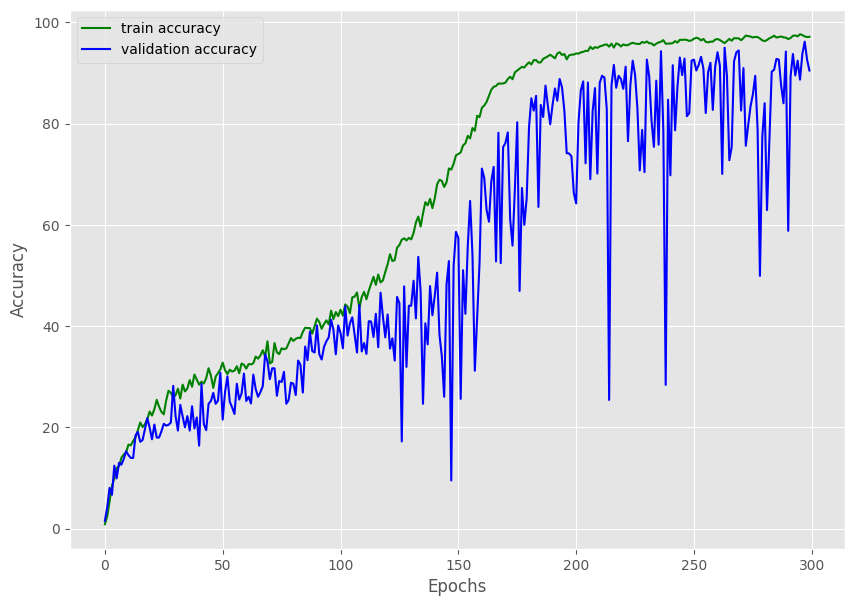

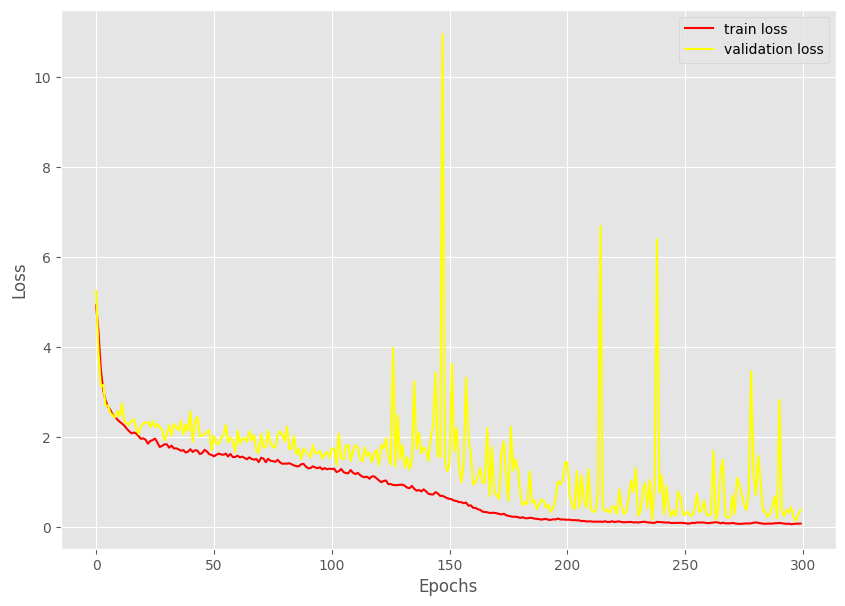

In [74]:
def train_model():
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    min_valid_loss = 2**31-1

    for epoch in range(epochs):
        print(f'[INFO]: Epoch {epoch+1}/{epochs}')
        train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
        valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion)

        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)

        print(f'Training loss: {train_epoch_loss:.3f}\tTraining Accuracy: {train_epoch_acc:.2f}')
        print(f'Validation loss: {valid_epoch_loss:.3f}\tValidation Accuracy: {valid_epoch_acc:.2f}')
        if valid_epoch_loss < min_valid_loss:
            min_valid_loss = valid_epoch_loss
            save_model(epochs, model, optimizer, criterion, save_dir, is_best=True)
        save_model(epochs, model, optimizer, criterion, save_dir, is_best=False)
        print()
    save_plots(train_acc, valid_acc, train_loss, valid_loss, save_dir)
    print('TRAINING COMPLETE')

train_model()


### Load the trained model

In [76]:
# Load the pretrained model
model = ResNetModel18(num_classes=144, weights=True)
model.to(device);
model.load_state_dict(torch.load('resnet18_outputs/best.pth', map_location=device)['state_dict'])
model.eval();

### Evaluation Functions

In [77]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_norm = np.divide(conf_matrix, row_sums, where=row_sums != 0)
    
    sns.heatmap(conf_matrix_norm, annot=True, fmt=".2%", cmap="crest")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [78]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate precision, recall, and F1 score for each class
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f1 = f1_score(y_true, y_pred, average=None)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    # plot_confusion_matrix(conf_matrix)
    print(f'Average Precision: {np.mean(precision):.4f}')
    print(f'Average Recall: {np.mean(recall):.4f}')
    print(f'Average F1 score: {np.mean(f1):.4f}')

    # Print the results
    for i in range(len(precision)):
        print(f"Class {i} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")
    
    return precision, recall, f1, conf_matrix

In [79]:
# Evaluate uring train dataset
precision, recall, f1, cm = evaluate_model(model, train_loader, device=device)

100%|██████████| 23/23 [00:40<00:00,  1.77s/it]

Average Precision: 0.9526
Average Recall: 0.9491
Average F1 score: 0.9494
Class 0 - Precision: 0.9398, Recall: 0.9750, F1 Score: 0.9571
Class 1 - Precision: 0.9595, Recall: 0.8875, F1 Score: 0.9221
Class 2 - Precision: 1.0000, Recall: 0.8875, F1 Score: 0.9404
Class 3 - Precision: 0.9872, Recall: 0.9625, F1 Score: 0.9747
Class 4 - Precision: 0.9865, Recall: 0.9125, F1 Score: 0.9481
Class 5 - Precision: 1.0000, Recall: 0.9625, F1 Score: 0.9809
Class 6 - Precision: 1.0000, Recall: 0.9875, F1 Score: 0.9937
Class 7 - Precision: 0.9870, Recall: 0.9500, F1 Score: 0.9682
Class 8 - Precision: 0.9872, Recall: 0.9625, F1 Score: 0.9747
Class 9 - Precision: 0.9872, Recall: 0.9625, F1 Score: 0.9747
Class 10 - Precision: 1.0000, Recall: 0.9125, F1 Score: 0.9542
Class 11 - Precision: 0.9620, Recall: 0.9500, F1 Score: 0.9560
Class 12 - Precision: 0.9870, Recall: 0.9500, F1 Score: 0.9682
Class 13 - Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9474
Class 14 - Precision: 0.9744, Recall: 0.9500, F1 Score

In [80]:
# Evaluate uring validation dataset
precision, recall, f1, cm = evaluate_model(model, valid_loader, device=device)

100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

Average Precision: 0.9662
Average Recall: 0.9618
Average F1 score: 0.9616
Class 0 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class 1 - Precision: 0.7692, Recall: 1.0000, F1 Score: 0.8696
Class 2 - Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524
Class 3 - Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524
Class 4 - Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524
Class 5 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class 6 - Precision: 1.0000, Recall: 0.8000, F1 Score: 0.8889
Class 7 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class 8 - Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524
Class 9 - Precision: 0.9000, Recall: 0.9000, F1 Score: 0.9000
Class 10 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class 11 - Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524
Class 12 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class 13 - Precision: 1.0000, Recall: 0.8000, F1 Score: 0.8889
Class 14 - Precision: 1.0000, Recall: 1.0000, F1 Score

In [81]:
# Evaluate uring test dataset
precision, recall, f1, cm = evaluate_model(model, test_loader, device=device)

100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

Average Precision: 0.9401
Average Recall: 0.9340
Average F1 score: 0.9332
Class 0 - Precision: 1.0000, Recall: 0.8000, F1 Score: 0.8889
Class 1 - Precision: 0.9000, Recall: 0.9000, F1 Score: 0.9000
Class 2 - Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Class 3 - Precision: 1.0000, Recall: 0.8000, F1 Score: 0.8889
Class 4 - Precision: 0.9091, Recall: 1.0000, F1 Score: 0.9524
Class 5 - Precision: 0.9000, Recall: 0.9000, F1 Score: 0.9000
Class 6 - Precision: 1.0000, Recall: 0.8000, F1 Score: 0.8889
Class 7 - Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9474
Class 8 - Precision: 1.0000, Recall: 0.7000, F1 Score: 0.8235
Class 9 - Precision: 0.8333, Recall: 1.0000, F1 Score: 0.9091
Class 10 - Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9474
Class 11 - Precision: 0.9000, Recall: 0.9000, F1 Score: 0.9000
Class 12 - Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9474
Class 13 - Precision: 1.0000, Recall: 0.9000, F1 Score: 0.9474
Class 14 - Precision: 0.9091, Recall: 1.0000, F1 Score

### Inference

In [82]:
labels = train_dataset.classes

In [87]:
inference_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) 

In [88]:
def inference(path, save_dir='./outputs'):
    # If the path is a image file
    if os.path.isfile(path):
        if path.endswith('.jpg') or path.endswith('.png') or filename.path('.jpeg') \
                or path.endswith('.JPG') or path.endswith('.PNG') or path.endswith('.JPEG'):
            image = cv2.imread(path)
            gt_class = path.split('/')[-2]
            orig_image = image.copy()
            # convert to RGB format
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = inference_transform(image)
            image = torch.unsqueeze(image, 0)
            with torch.no_grad():
                outputs = model(image.to(device))
            output_label = torch.topk(outputs, 1)
            pred_class = labels[int(output_label.indices)]
            cv2.putText(orig_image, 
                f"GT: {gt_class}",
                (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (255, 255, 255), 2, cv2.LINE_AA
            )
            cv2.putText(orig_image, 
                f"Pred: {pred_class}",
                (10, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (255, 255, 255), 2, cv2.LINE_AA
            )
            print(f"GT: {gt_class}, pred: {pred_class}")
            cv2.imwrite(f"outputs/{path.split('/')[-1]}", orig_image)
    # If the file is a directory
    elif os.path.isdir(path):
        save_dir = os.path.join(save_dir, os.path.basename(os.path.normpath(path)))
        os.makedirs(save_dir, exist_ok=True)
        files = os.listdir(path)
        correct_prediction = 0
        incorrect_prediction = 0
        for filename in tqdm(files):
            if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg') \
                or filename.endswith('.JPG') or filename.endswith('.PNG') or filename.endswith('.JPEG'):
                image_path = os.path.join(path, filename)
                save_image_path = os.path.join(save_dir, filename)
                image = cv2.imread(image_path)
                gt_class = image_path.split('/')[-2]

                orig_image = image.copy()
                # convert to RGB format
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = inference_transform(image)
                image = torch.unsqueeze(image, 0)
                with torch.no_grad():
                    outputs = model(image.to(device))
                output_label = torch.topk(outputs, 1)
                pred_class = labels[int(output_label.indices)]
                cv2.putText(orig_image, 
                    f"GT: {gt_class}",
                    (10, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.6, (0, 255, 0), 2, cv2.LINE_AA
                )
                cv2.putText(orig_image, 
                    f"Pred: {pred_class}",
                    (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    0.6, (255, 0, 0), 2, cv2.LINE_AA
                )
                if gt_class == pred_class:
                    correct_prediction+=1
                else:
                    incorrect_prediction+=1
                cv2.imwrite(save_image_path, orig_image)
        print(f'Total images: {correct_prediction + incorrect_prediction}')
        print(f'Correct prediction: {correct_prediction}')
        print(f'Incorrect prediction: {incorrect_prediction}')

In [93]:
image_dir = '/media/imran4070/SSD/imran/datasets/classification/time/test/1-20'
save_dir = 'resnet18_outputs/test/'
inference(image_dir, save_dir)

100%|██████████| 10/10 [00:00<00:00, 274.96it/s]

Total images: 10
Correct prediction: 10
Incorrect prediction: 0
